In [3]:

from template_match import read_image_rgb, read_image_gray, template_match, \
    detect_points, find_tolerance_limit, simplify_points, point_to_bbox, agglomerative_clustering, meanshift_clustering

from process_template import template_tresholding, extract_largest_component, find_bbox, \
    crop_image, frame_image, is_grayscale

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import numpy_indexed as npi
from tqdm.notebook import tqdm

In [5]:
from ipywidgets import interact, widgets
from plotly.express import imshow as imshow_interactive

In [6]:
def draw_image(image: np.ndarray) -> None:
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))


def draw_points_on_canvas(points: np.ndarray, image: np.ndarray) -> None:
    x = points[:, 0]
    y = points[:, 1]
    
    clear_canvas = image.copy()
    clear_canvas[:, :] = 255
    plt.scatter(x, y, alpha=0.5, s=20)
    plt.imshow(cv.cvtColor(clear_canvas, cv.COLOR_BGR2RGB))

def draw_points_on_image(
        points: np.ndarray, image: np.ndarray, w: int, h: int,
        markersize=20, alpha=0.5, color="C0"
) -> None:
    x = np.copy(points[:, 0])
    y = np.copy(points[:, 1])
    x += w // 2 - 1
    y += h // 2 - 1
    plt.scatter(x, y, alpha=alpha, s=markersize, color=color)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))


from matplotlib.patches import Rectangle

def draw_bbox(x_min, x_max, y_min, y_max, bbox_center=None) -> None:
    height = y_max - y_min
    width = x_max - x_min
    rect = Rectangle((x_min, y_min), width, height, edgecolor='r', facecolor='none')
    ax = plt.gca()
    ax.add_patch(rect)

    if bbox_center:
        bbox_center_x, bbox_center_y = bbox_center
        plt.scatter([bbox_center_x], [bbox_center_y], marker="*")

In [70]:
import os
import pathlib
from typing import List, Tuple
import numpy as np
import cv2 as cv
from sklearn.cluster import AgglomerativeClustering
from dotenv import load_dotenv
from setup_logger import logger


BASE_DIR = pathlib.Path(__name__).resolve().parent.parent
load_dotenv(BASE_DIR / '.env')
DATA_PATH = pathlib.Path(os.getenv("DATA_PATH"))

DESKTOP_PATH = pathlib.Path(os.getenv("DESKTOP_PATH"))

In [104]:
PLOT_NUMBER = 10
MARKER_NUMBER = 1

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_same_shape" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"
# TEMPLATE_PATH = DATA_PATH / "markers_same_shape" / f"plot9_marker{MARKER_NUMBER}.png"

# PLOT_PATH = DATA_PATH / "generated_plots" / f"plot_{PLOT_NUMBER}.png"
# TEMPLATE_PATH = DATA_PATH / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"
# TEMPLATE_PATH = DATA_PATH / "generated_plots" / "markers" / f"plot_{PLOT_NUMBER}_marker_{MARKER_NUMBER}.png"

In [105]:
source_image = read_image_rgb(PLOT_PATH)

template_rgb = read_image_rgb(TEMPLATE_PATH)
w, h = template_rgb.shape[1], template_rgb.shape[0]

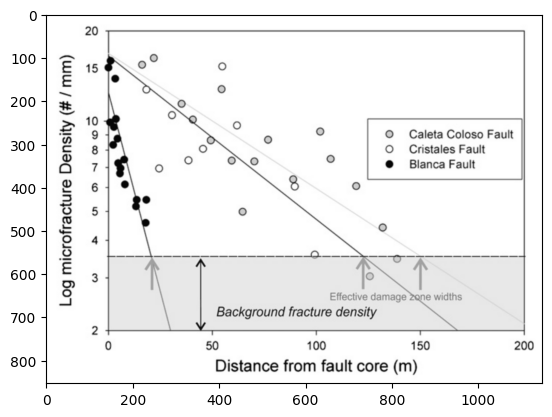

In [106]:
draw_image(source_image)

(0.0, 256.0)

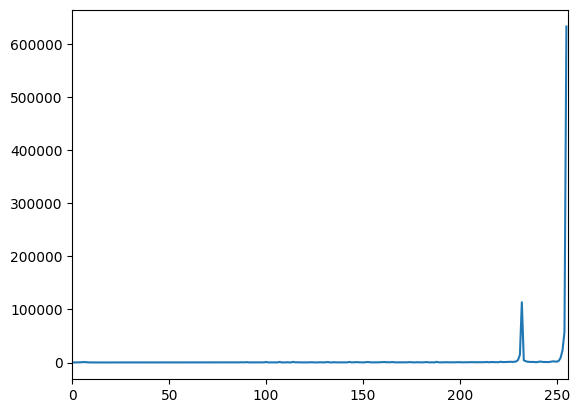

In [107]:
hist = cv.calcHist([source_image], [0], None, [256], [0, 256])
plt.plot(hist)
plt.xlim([0, 256])

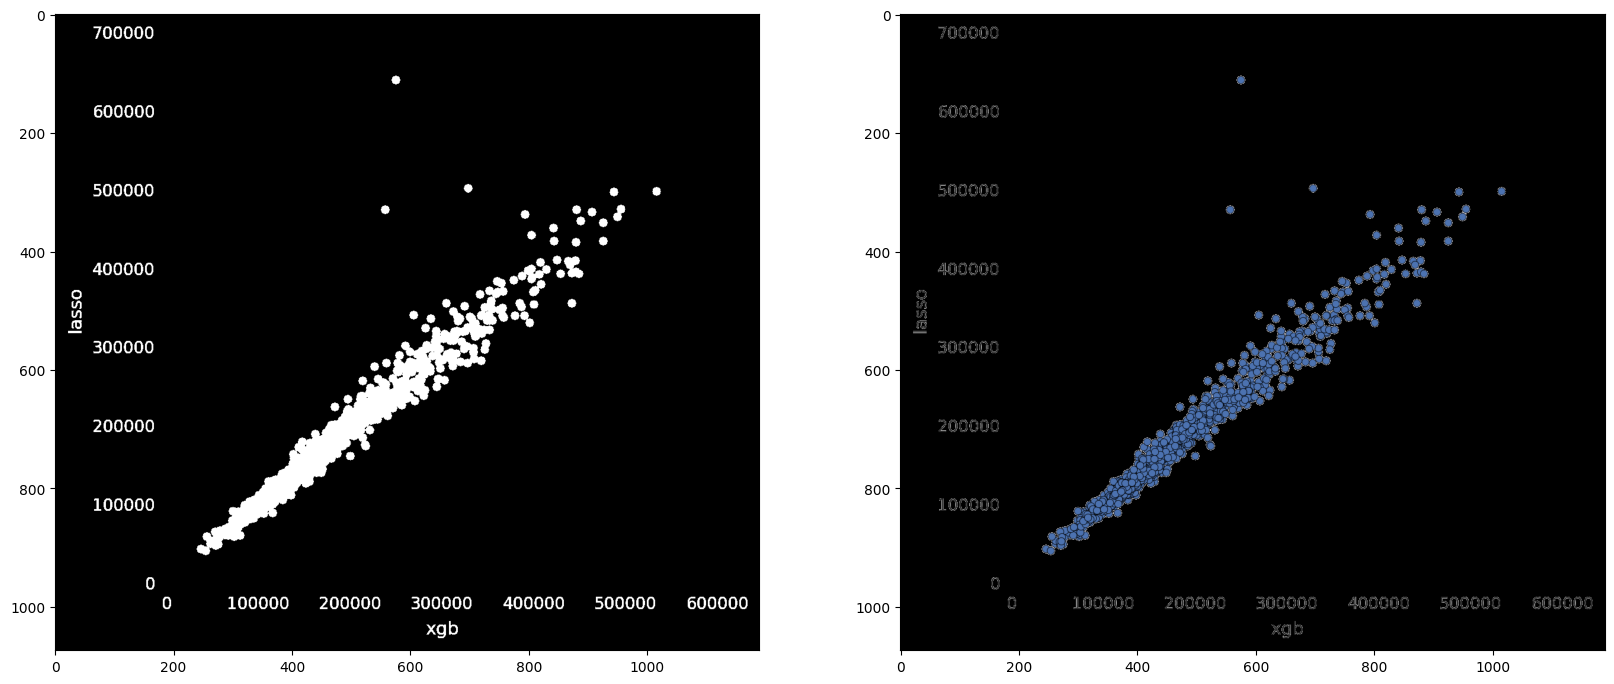

In [103]:
tresh = 230

image_mask = template_tresholding(source_image, treshold=tresh)

indexes_background = np.where(image_mask == 0)
image = np.copy(source_image)
image[indexes_background] = 0

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
draw_image(image_mask)

plt.subplot(1, 2, 2)
draw_image(image)

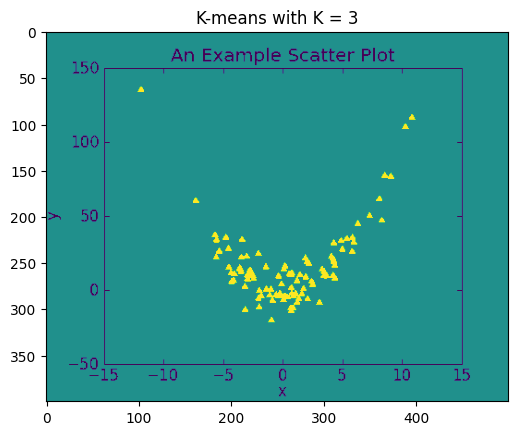

In [76]:
# load image
img1 = np.copy(source_image)

Z = img1.reshape((-1, 3))
# convert to np.float32
Z = np.float32(Z)

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  
K = 3

ret, label, center = cv.kmeans(Z, K, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

plt.title(f'K-means with K = {K}')
plt.imshow(label.reshape(img1[:, :, 0].shape))